### Basic Concepts: Nodes, Edges & State

In [1]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

### Visualize graph

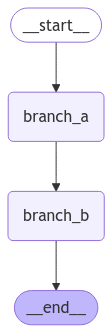

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [5]:
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [6]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current value: {'string_value': 'a', 'numeric_value': 1}


{'string_value': 'a', 'numeric_value': 1}

In [7]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [8]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [9]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [10]:
from langchain_core.runnables import RunnableLambda

In [11]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable

In [12]:
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Cycles and Conditional Edges

In [19]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_node("branch_c",modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b","branch_c")
graph.add_edge(START, "branch_a")

graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)
graph.add_conditional_edges(
    "branch_c", router, {"branch_a": "branch_c", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

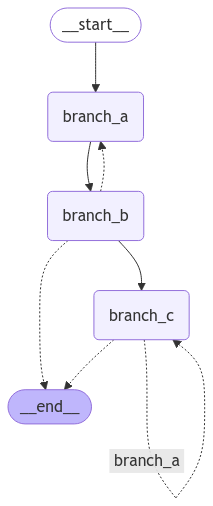

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

InvalidUpdateError: At key 'string_value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

### Reducer functions

In [22]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [23]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [24]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [29]:
from typing import TypedDict
from langgraph.graph import END, StateGraph
from pydantic import BaseModel

#class InputState(TypedDict):
#    string_value: str
#    numeric_value: int


class InputState(BaseModel):
       string_value: str
       numeric_value: int


def modify_state(input: InputState):
    # string_value = input["string_value"] # TypedDict
    string_value = input.string_value # Pydantic
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [31]:
runnable.invoke({"string_value": "a", "numeric_value": 49})

a
a


{'string_value': 'a', 'numeric_value': 49}